Загрузка данных Бостонского марафона (2015-2017)...
Using Colab cache for faster access to the 'boston-results' dataset.
Рассчитываю динамику темпа по отрезкам...
База данных готова: 78656 бегунов.


/tmp/ipython-input-3238100132.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['age_group', 'temp'])['wall_index'].mean().unstack()



 СТАТИСТИКА: Среднее замедление после 30 км (%)
temp              9          16         23
age_group                                 
18-30      11.484870  18.363412  18.654985
30-40      10.810351  17.460366  17.689184
40-50      11.173594  17.567090  18.343132
50-60      12.806718  18.832736  19.547211
60+        15.379760  19.219632  20.966649

 АНАЛИЗ:
✅ Все хорошо. Замедление при 30°C составит всего 11.9%.


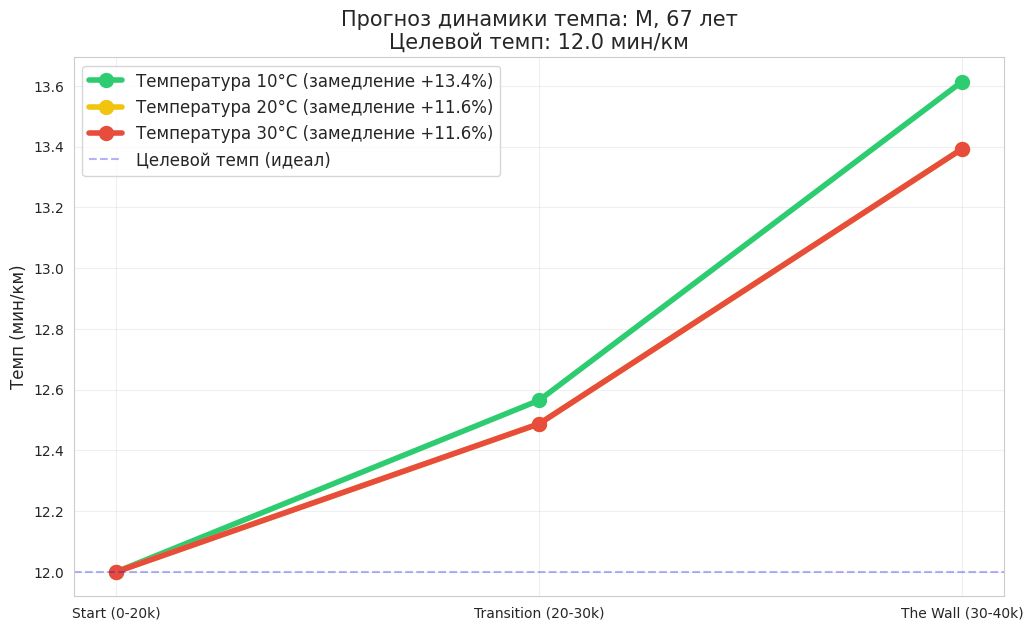

In [17]:
!pip install kagglehub catboost -q

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# визуал
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# данные
def load_and_process_marathon_data():
    print("Загрузка данных Бостонского марафона (2015-2017)...")
    path = kagglehub.dataset_download("rojour/boston-results")

    all_files = glob.glob(f"{path}/**/*.csv", recursive=True)
    weather_map = {
        2015: {'temp': 9, 'hum': 85, 'wind': 25},
        2016: {'temp': 16, 'hum': 55, 'wind': 15},
        2017: {'temp': 23, 'hum': 45, 'wind': 10}
    }

    def to_min(val):
        try:
            p = str(val).strip().split(':')
            if len(p) == 3: return int(p[0])*60 + int(p[1]) + float(p[2])/60
            return np.nan
        except: return np.nan

    full_list = []
    for f in all_files:
        year = next((y for y in [2015, 2016, 2017] if str(y) in f), None)
        if year:
            df = pd.read_csv(f)
            df.columns = df.columns.str.lower().str.strip().str.replace('.', '', regex=False)
            df['year'] = year
            df['temp'] = weather_map[year]['temp']
            df['hum'] = weather_map[year]['hum']
            df['wind'] = weather_map[year]['wind']
            full_list.append(df)

    data = pd.concat(full_list, ignore_index=True)

    # темп по отрезкам
    print("Рассчитываю динамику темпа по отрезкам...")
    # 0-20км (старт), 20-30км (переход), 30-40км (критическая зона)
    data['p_start'] = data['20k'].apply(to_min) / 20
    data['p_mid'] = (data['30k'].apply(to_min) - data['20k'].apply(to_min)) / 10
    data['p_wall'] = (data['40k'].apply(to_min) - data['30k'].apply(to_min)) / 10

    # на сколько % темп на "стене" выше темпа на старте
    data['wall_index'] = (data['p_wall'] - data['p_start']) / data['p_start'] * 100

    # очистка данных
    data['gender'] = data['m/f'].apply(lambda x: 'M' if str(x).upper().startswith('M') else 'F')
    data = data[(data['wall_index'] > -5) & (data['wall_index'] < 100)].dropna(subset=['wall_index', 'age'])

    print(f"База данных готова: {len(data)} бегунов.")
    return data

# обучение
def train_wall_model(df):
    features = ['age', 'gender', 'p_start', 'temp', 'hum', 'wind']
    X = df[features]
    y = df['wall_index']

    model = CatBoostRegressor(iterations=800, learning_rate=0.05, depth=6, verbose=0)
    model.fit(X, y, cat_features=['gender'])
    return model

# генерация данных и визуализация
def final_report(model, df, user_age, user_gender, user_start_pace):
    # 1. группировка
    df['age_group'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 80], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
    summary = df.groupby(['age_group', 'temp'])['wall_index'].mean().unstack()
    print("\n СТАТИСТИКА: Среднее замедление после 30 км (%)")
    print(summary)

    # 2. построение графика
    temps_plot = [10, 20, 30]
    colors = ['#2ecc71', '#f1c40f', '#e74c3c'] # Зеленый, Желтый, Красный
    labels = ['Start (0-20k)', 'Transition (20-30k)', 'The Wall (30-40k)']

    plt.figure(figsize=(12, 7))

    for t, col in zip(temps_plot, colors):
        # предсказываем индекс замедления
        h_val = 80 if t == 10 else (50 if t == 20 else 30)
        input_row = pd.DataFrame([[user_age, user_gender, user_start_pace, t, h_val, 10]],
                         columns=['age', 'gender', 'p_start', 'temp', 'hum', 'wind'])

        wall_pct = model.predict(input_row)[0]

        # три точки темпа
        # 1: начальный темп
        # 2: начало усталости (берем 30% от предсказанного замедления)
        # 3: финальный темп
        pace_points = [
            user_start_pace,
            user_start_pace * (1 + (wall_pct * 0.35) / 100),
            user_start_pace * (1 + wall_pct / 100)
        ]

        plt.plot(labels, pace_points, marker='o', markersize=10, lw=4, color=col,
                 label=f'Температура {t}°C (замедление +{wall_pct:.1f}%)')

    plt.axhline(user_start_pace, ls='--', color='blue', alpha=0.3, label='Целевой темп (идеал)')
    plt.title(f"Прогноз динамики темпа: {user_gender}, {user_age} лет\nЦелевой темп: {user_start_pace} мин/км", fontsize=15)
    plt.ylabel("Темп (мин/км)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # УЖАСЫ
    print("\n АНАЛИЗ:")
    hot_input = pd.DataFrame([[user_age, user_gender, user_start_pace, 30, 60, 10]], columns=['age', 'gender', 'p_start', 'temp', 'hum', 'wind'])
    hot_wall = model.predict(hot_input)[0]

    if hot_wall > 12:
        print(f" Внимание: При 30°C ожидается критическое замедление (+{hot_wall:.1f}%).")
        print(f" Рекомендация: начните на {int(hot_wall * 1.5)} сек/км медленнее целевого темпа.")
    else:
        print(f"✅ Все хорошо. Замедление при 30°C составит всего {hot_wall:.1f}%.")

    plt.show()

# Запуск
try:
    data = load_and_process_marathon_data()
    model = train_wall_model(data)

    # Параметры для теста:
    final_report(model, data,
                 user_age=67,
                 user_gender='M',
                 user_start_pace=12.0) # Целевой темп 5:00 мин/км
except Exception as e:
    print(f"❌ Ошибка: {e}")